# This notebook is for smart home

In [1]:
!pip install tensorflow==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 KB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.11.2
    Uninstalling tensorboard-2.11.2:
      Successfully uninstalled tensorboard-2.11.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.11.0
    Uninstalling tensorflow-2.11.0:
      Successfully uninstalled tensorflow-2.11.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check GPU status

In [3]:
!nvidia-smi

Sun Feb 12 10:16:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the helper functions

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-12 10:16:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-12 10:16:47 (108 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Import dataset

In [6]:
train_dir = "/content/drive/MyDrive/Smart_house/Data/training"
test_dir = "/content/drive/MyDrive/Smart_house/Data/test"

## Get information about the dataset

In [7]:
walk_through_dir('/content/drive/MyDrive/Smart_house/Data')

There are 2 directories and 0 images in '/content/drive/MyDrive/Smart_house/Data'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Smart_house/Data/test'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Smart_house/Data/test/A'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Smart_house/Data/test/B'.
There are 0 directories and 20 images in '/content/drive/MyDrive/Smart_house/Data/test/C'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Smart_house/Data/training'.
There are 0 directories and 80 images in '/content/drive/MyDrive/Smart_house/Data/training/A'.
There are 0 directories and 80 images in '/content/drive/MyDrive/Smart_house/Data/training/B'.
There are 0 directories and 80 images in '/content/drive/MyDrive/Smart_house/Data/training/C'.


## Setup data inputs

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False
)

Found 240 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


# Training the model

In [9]:
# Adding model checkpoint
checkpoint_path = "model_1_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# Create a data augmentation layer to build data augmentation right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescale(1/255.) # DOES NOT NEEDED SINCE EFFIENETB0 HAS BUILT IN
], name="data_augmentation")

In [11]:
# setup the base model and frezee its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens in training phase)
x = base_model(x, training=False) # weights will be frozen
x = layers.GlobalAveragePooling2D(name="Global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
batch2_model_1 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 2s 0us/step


In [12]:
batch2_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable

In [13]:
# compile
batch2_model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# fit the model
batch2_model_1_history = batch2_model_1.fit(train_data,
                            epochs=10,
                            validation_data=test_data,
                            validation_steps=int(len(test_data)),
                            callbacks=[checkpoint_callback])

Epoch 1/10
8/8 [==============================] - 131s 4s/step - loss: 0.7992 - accuracy: 0.7500 - val_loss: 0.4228 - val_accuracy: 1.0000
Epoch 2/10
8/8 [==============================] - 22s 829ms/step - loss: 0.3200 - accuracy: 0.9958 - val_loss: 0.1670 - val_accuracy: 1.0000
Epoch 3/10
8/8 [==============================] - 22s 832ms/step - loss: 0.1516 - accuracy: 0.9958 - val_loss: 0.0834 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 23s 961ms/step - loss: 0.0889 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 1.0000
Epoch 5/10
8/8 [==============================] - 22s 818ms/step - loss: 0.0682 - accuracy: 0.9958 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 6/10
8/8 [==============================] - 22s 809ms/step - loss: 0.0505 - accuracy: 0.9958 - val_loss: 0.0293 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 21s 751ms/step - loss: 0.0435 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 8/10
8/8 

In [14]:
feature_extraction_result = batch2_model_1.evaluate(test_data)
feature_extraction_result

2/2 [==============================] - 3s 1s/step - loss: 0.0158 - accuracy: 1.0000


[0.01580236293375492, 1.0]

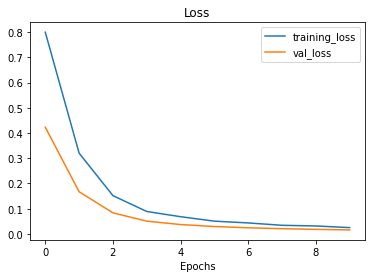

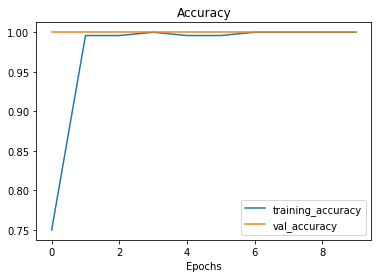

In [15]:
plot_loss_curves(batch2_model_1_history)

# Fine-tuning

In [16]:
# unfreez all of the layers in the base-model
base_model.trainable = True

# refreez every layer except the last five layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# recompile model with lower learning rate
batch2_model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [18]:
# what layers in the model trainable?
for layer in batch2_model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
Global_average_pooling_layer True
output_layer True


In [19]:
# check which layers are trainable in our base-model
for layer_number, layer in enumerate(batch2_model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# fine-tune for 5 more epochs
fine_tune_epochs = 20

# fine-tune our model
history_model_1_fine_tune = batch2_model_1.fit(train_data,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(len(test_data)),
                                      initial_epoch=batch2_model_1_history.epoch[-1])

Epoch 10/20
8/8 [==============================] - 31s 978ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 11/20
8/8 [==============================] - 21s 806ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 12/20
8/8 [==============================] - 21s 780ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 6.3015e-04 - val_accuracy: 1.0000
Epoch 13/20
8/8 [==============================] - 21s 758ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 3.7891e-04 - val_accuracy: 1.0000
Epoch 14/20
8/8 [==============================] - 23s 997ms/step - loss: 8.4798e-04 - accuracy: 1.0000 - val_loss: 2.8811e-04 - val_accuracy: 1.0000
Epoch 15/20
8/8 [==============================] - 21s 739ms/step - loss: 7.6467e-04 - accuracy: 1.0000 - val_loss: 2.3038e-04 - val_accuracy: 1.0000
Epoch 16/20
8/8 [==============================] - 21s 733ms/step - loss: 3.4861e-04 - accuracy: 1.0000 - val_loss: 1.8617e-

In [ ]:
# evaluate on the wholes test data
model_1_fine_tune_results = batch2_model_1.evaluate(test_data)
model_1_fine_tune_results

2/2 [==============================] - 3s 1s/step - loss: 9.3552e-05 - accuracy: 1.0000


[9.355192742077634e-05, 1.0]

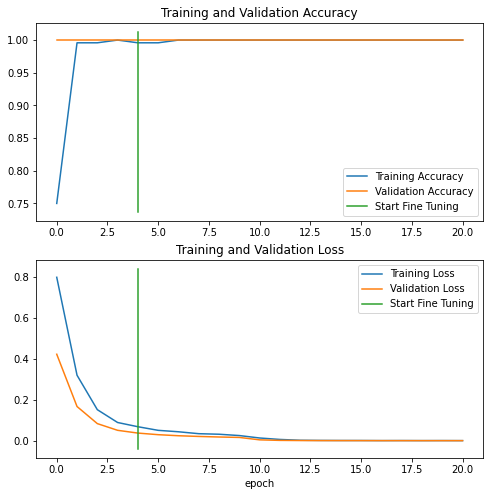

In [ ]:
# compare the histories of feature extraction model with fine-tuining model
compare_historys(original_history=batch2_model_1_history,
                 new_history=history_model_1_fine_tune,
                 initial_epochs=5)

# Saving model

In [ ]:
# save our fine-tuned model
batch2_model_1.save("batch2_model_1.h5")

In [ ]:
tf.__version__

'2.8.0'

# Making predictions with our trained model

In [ ]:
# make predictions
preds_probs = batch2_model_1.predict(test_data, verbose=1)

2/2 [==============================] - 5s 2s/step


In [ ]:
# how many predictions are there?
len(preds_probs)

60

In [ ]:
# what is the shape of our predictions
preds_probs.shape

(60, 3)

In [ ]:
# let's check the first 10 predictions looks like?
preds_probs[:10]

array([[9.9988675e-01, 7.0574315e-05, 4.2643685e-05],
       [9.9994588e-01, 3.3806104e-05, 2.0220341e-05],
       [9.9959666e-01, 2.7726853e-04, 1.2602098e-04],
       [9.9959475e-01, 1.8185552e-04, 2.2341791e-04],
       [9.9990892e-01, 6.8993533e-05, 2.2062619e-05],
       [9.9998760e-01, 8.3629529e-06, 3.9996521e-06],
       [9.9998963e-01, 9.0254671e-06, 1.2676785e-06],
       [9.9998987e-01, 6.8211812e-06, 3.3240044e-06],
       [9.9999404e-01, 5.7610960e-06, 1.9376211e-07],
       [9.9998391e-01, 1.4643284e-05, 1.3845795e-06]], dtype=float32)

In [ ]:
# get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# how do they look
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# how many pred classes do we have
len(pred_classes)

60

In [ ]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1,0,...,0,0]
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Let's try sklearn accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

1.0

# Making confusion matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changed (plot x-label vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

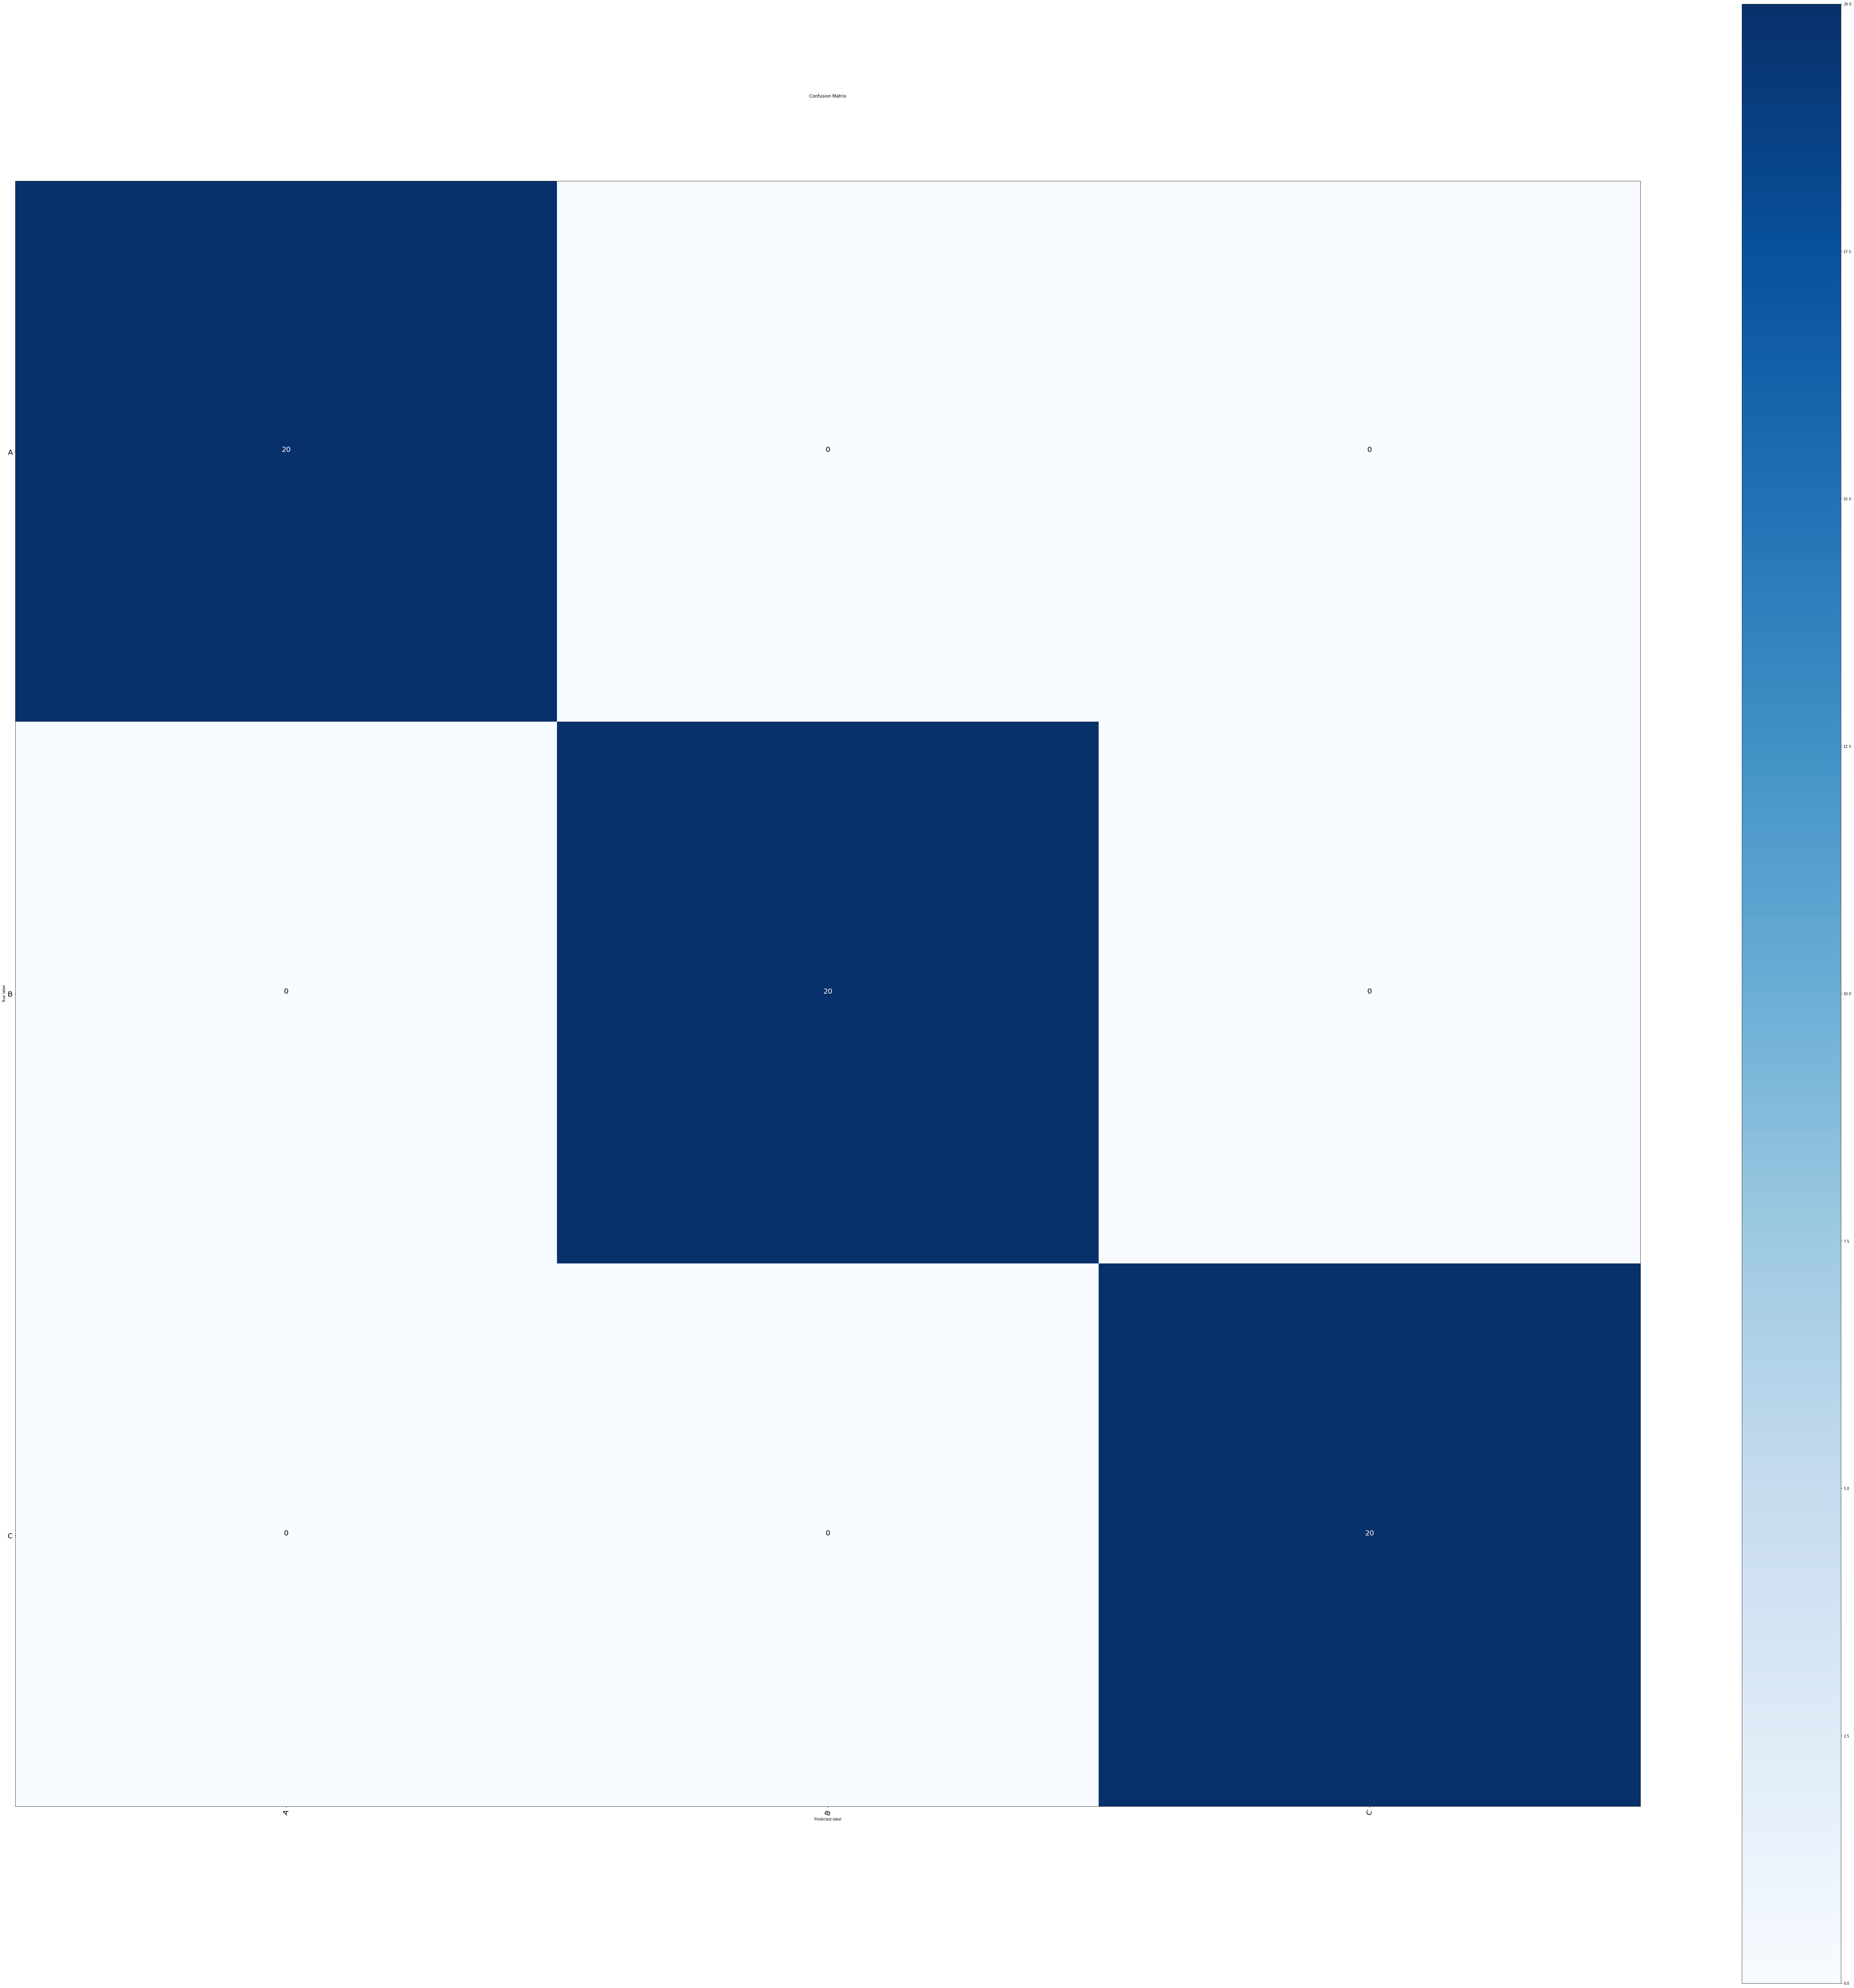

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20)

# Generate classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [ ]:
# get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# create empty dictionary
class_f1_scores = {}

# get class names from test data
class_names = test_data.class_names

# loop through classificationreport dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'A': 1.0, 'B': 1.0, 'C': 1.0}

In [ ]:
# turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores[:20]

,class_names,f1-score
0,A,1.0
1,B,1.0
2,C,1.0


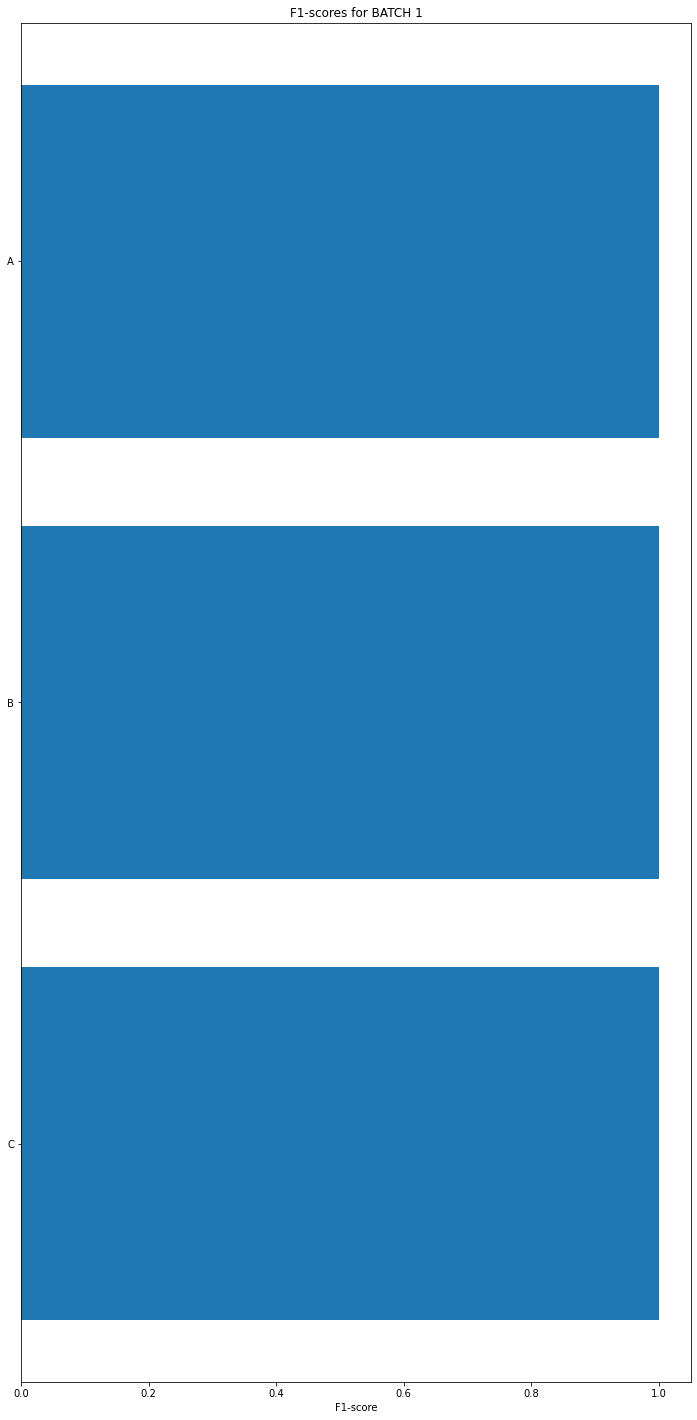

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for BATCH 1")
ax.invert_yaxis()

# Visualizing predictions on custom images

In [ ]:
# create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into
  specified shape (img_shape, img_shape, color_channels=3)
  """

  # read the target image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # scale yes/no
  if scale:
    return img/255
  else:
    return img

In [ ]:
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
  # choose random images(s) from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = batch2_model_1.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  # plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

NotFoundError: ignored

<Figure size 1440x720 with 0 Axes>

# Test the model on custom images